# Import Libraries, Project innit
Import all required libraries and set the visual theme (white background with brown/orange accents) for consistent visualizations throughout the notebook.

In [10]:
# Cell 1: Initial Setup and Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from prophet import Prophet

# Set the visual theme - white background with brown/orange accents
sns.set_theme(style="white", palette=["#8B4513", "#FFA500", "#D2B48C"])
print("✅ Libraries imported and theme set")

✅ Libraries imported and theme set


# Data Loading/ Cleaning
Load and clean the raw data from monthly CSV files, ensuring consistent formatting and handling of missing values before analysis.

In [14]:
# Cell 2: Data Loading and Preparation
# Load monthly CSV files
jan = pd.read_csv('sheets/jan25.csv')
feb = pd.read_csv('sheets/feb25.csv')
mar = pd.read_csv('sheets/march25.csv')
apr = pd.read_csv('sheets/apr25.csv')

# Add month identifiers to each dataset
jan['Month'] = 'January'
feb['Month'] = 'February'
mar['Month'] = 'March'
apr['Month'] = 'April'

# Combine all months into a single dataframe
combined = pd.concat([jan, feb, mar, apr], ignore_index=True)

# Clean column names and handle duplicates
combined.columns = combined.columns.str.strip()
combined = combined.loc[:,~combined.columns.duplicated()]

# Fill missing values and remove duplicates
combined.fillna(0, inplace=True)
combined = combined.drop_duplicates()

print("✅ Data loaded and cleaned")
print(f"Total records: {len(combined)}")
combined.head(10)

✅ Data loaded and cleaned
Total records: 82


,Hotel In General,Unnamed: 1,Excellent,V.Good,Good,Average,Poor,Total,Month
0,Quality Facilities,0.0,11,4,0.0,0,0.0,15,January
1,State of Repair,0.0,8,3,3.0,0,0.0,14,January
2,Cleanliness,0.0,10,4,0.0,0,0.0,14,January
3,Friendliness,0.0,12,1,1.0,0,0.0,14,January
4,Speed & Efficiency of check in,0.0,12,2,0.0,1,0.0,15,January
5,Speed & Efficiency of check out,0.0,12,2,1.0,0,0.0,15,January
6,Quality of Facilities,0.0,11,3,1.0,0,0.0,15,January
7,Cleanliness,0.0,11,1,0.0,0,0.0,12,January
8,Bed Comfort,0.0,14,0,0.0,0,0.0,14,January
9,Bathroom Cleanliness & hygiene,0.0,11,3,0.0,0,0.0,14,January


# Standardization
Transform raw counts into percentage values for each satisfaction level (Excellent to Poor) to enable standardized comparison across categories with different response volumes.

In [16]:
# Cell 3: Data Transformation - Calculate Satisfaction Percentages
def calculate_percentages(df):
    results = []
    for category in df['Hotel In General'].unique():
        if pd.isna(category):
            continue
            
        subset = df[df['Hotel In General'] == category]
        
        for month in subset['Month'].unique():
            month_data = subset[subset['Month'] == month]
            total = month_data['Total'].values[0]
            
            if total == 0:
                continue
                
            results.append({
                'Category': category,
                'Month': month,
                'Excellent %': month_data['Excellent'].values[0] / total * 100,
                'V.Good %': month_data['V.Good'].values[0] / total * 100,
                'Good %': month_data['Good'].values[0] / total * 100,
                'Average %': month_data['Average'].values[0] / total * 100,
                'Poor %': month_data['Poor'].values[0] / total * 100,
                'Total Responses': total
            })
    
    return pd.DataFrame(results)

percentages = calculate_percentages(combined)
print("✅ Satisfaction percentages calculated")
percentages.head(10)

✅ Satisfaction percentages calculated


,Category,Month,Excellent %,V.Good %,Good %,Average %,Poor %,Total Responses
0,Quality Facilities,January,73.333333,26.666667,0.000000,0.0,0.0,15
1,Quality Facilities,February,100.000000,0.000000,0.000000,0.0,0.0,7
2,Quality Facilities,March,75.000000,25.000000,0.000000,0.0,0.0,12
3,Quality Facilities,April,88.888889,11.111111,0.000000,0.0,0.0,18
4,State of Repair,January,57.142857,21.428571,21.428571,0.0,0.0,14
5,State of Repair,February,100.000000,0.000000,0.000000,0.0,0.0,7
6,State of Repair,March,75.000000,16.666667,8.333333,0.0,0.0,12
7,State of Repair,April,93.333333,0.000000,6.666667,0.0,0.0,15
8,Cleanliness,January,71.428571,28.571429,0.000000,0.0,0.0,14
9,Cleanliness,February,100.000000,0.000000,0.000000,0.0,0.0,7


## Satisfaction Trend
Show how satisfaction levels across all categories have evolved month-over-month, highlighting seasonal patterns or overall improvements/declines.

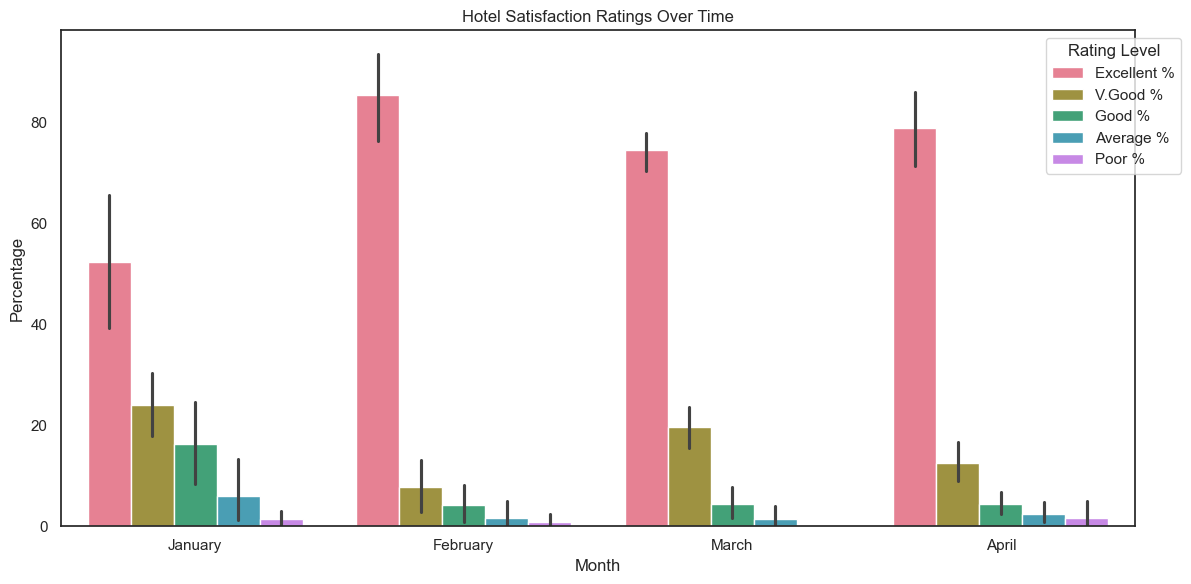

In [17]:
# Cell 4: Visualization 1 - Overall Satisfaction Trends
plt.figure(figsize=(12, 6))
melted = percentages.melt(id_vars=['Category', 'Month'], 
                         value_vars=['Excellent %', 'V.Good %', 'Good %', 'Average %', 'Poor %'],
                         var_name='Satisfaction Level', 
                         value_name='Percentage')

sns.barplot(x='Month', y='Percentage', hue='Satisfaction Level', data=melted,
            order=['January', 'February', 'March', 'April'])
plt.title('Hotel Satisfaction Ratings Over Time')
plt.legend(title='Rating Level', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### Wifi Connectivity Focus
Focus on Wi-Fi connectivity - typically a problematic area for hotels - to show how different satisfaction levels have changed, helping identify if improvements are reaching guests.

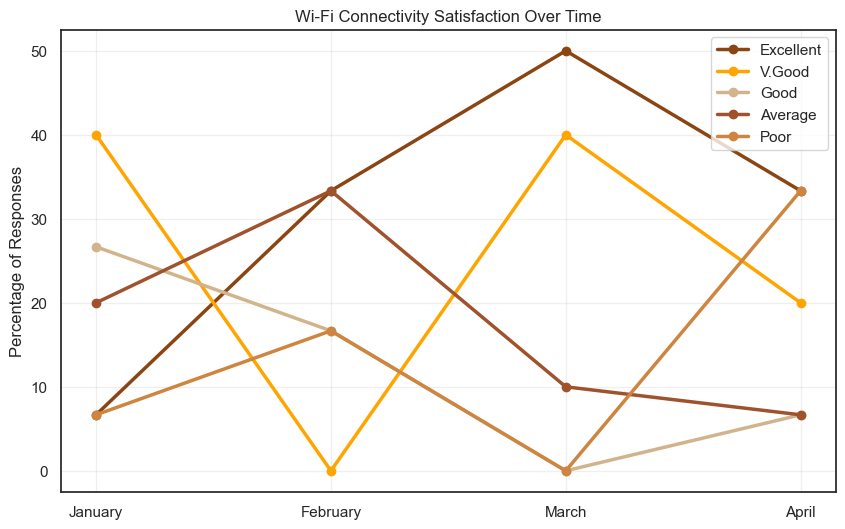

In [18]:
# Cell 5: Visualization 2 - Wi-Fi Connectivity Deep Dive
wifi_data = percentages[percentages['Category'] == 'Wi-Fi Connectivity']

plt.figure(figsize=(10, 6))
for column, color in zip(['Excellent %', 'V.Good %', 'Good %', 'Average %', 'Poor %'], 
                        ['#8B4513', '#FFA500', '#D2B48C', '#A0522D', '#CD853F']):
    plt.plot(wifi_data['Month'], wifi_data[column], label=column.split(' %')[0], 
             marker='o', color=color, linewidth=2.5)
    
plt.title('Wi-Fi Connectivity Satisfaction Over Time')
plt.ylabel('Percentage of Responses')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Staff Friendliness Analysis
Track staff friendliness (a key driver of guest satisfaction) by showing the percentage of "Excellent" ratings over time.

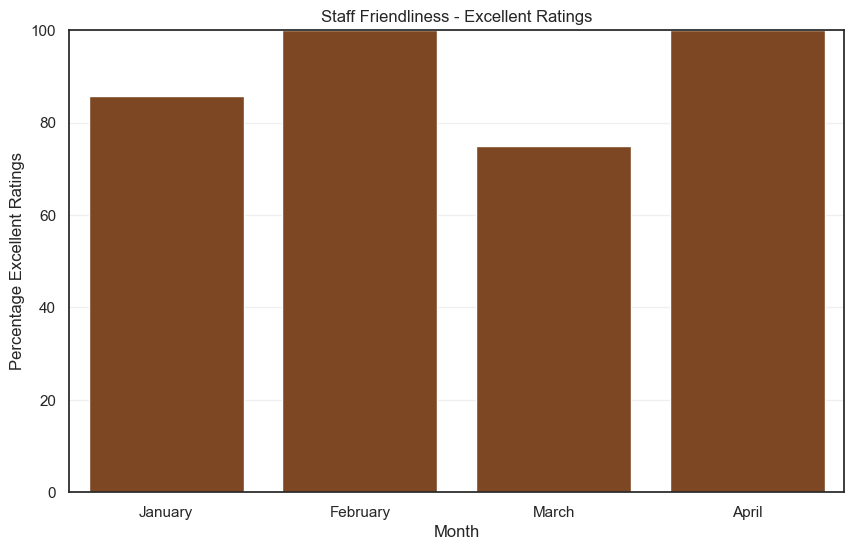

In [19]:
# Cell 6: Visualization 3 - Staff Friendliness Analysis
friendliness_data = percentages[percentages['Category'] == 'Friendliness']

plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Excellent %', data=friendliness_data, 
            order=['January', 'February', 'March', 'April'], 
            color='#8B4513')
plt.title('Staff Friendliness - Excellent Ratings')
plt.ylabel('Percentage Excellent Ratings')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)
plt.show()

### Average Scores
Create a weighted satisfaction score (5=Excellent to 1=Poor) to objectively rank service aspects and identify priority areas for improvement.

In [22]:
# Cell 7: Weighted Score Calculation
avg_scores = percentages.groupby('Category').mean(numeric_only=True)
avg_scores['Weighted Score'] = (avg_scores['Excellent %']*5 + 
                               avg_scores['V.Good %']*4 + 
                               avg_scores['Good %']*3 + 
                               avg_scores['Average %']*2 + 
                               avg_scores['Poor %']*1) / 100
avg_scores = avg_scores.sort_values('Weighted Score', ascending=False)

print("Top 3 Categories by Satisfaction:")
avg_scores.head(3)[['Weighted Score']]

Top 3 Categories by Satisfaction:


,Weighted Score
Category,
Friendliness,4.883929
Cleanliness,4.873016
Bathroom Cleanliness & hygiene,4.869223


In [23]:
print("\nBottom 3 Categories by Satisfaction:")
avg_scores.tail(3)[['Weighted Score']]


Bottom 3 Categories by Satisfaction:


,Weighted Score
Category,
Variety of Food,4.154798
Pricing,3.812500
Wi-Fi Connectivity,3.408333


#### Visualize Average Scores
Visualize the weighted scores to quickly identify strongest and weakest performance areas using a color gradient (brown=best, orange=mid, tan=needs improvement).

C:\Users\jack\AppData\Local\Temp\ipykernel_21940\2593062585.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=avg_scores.index,


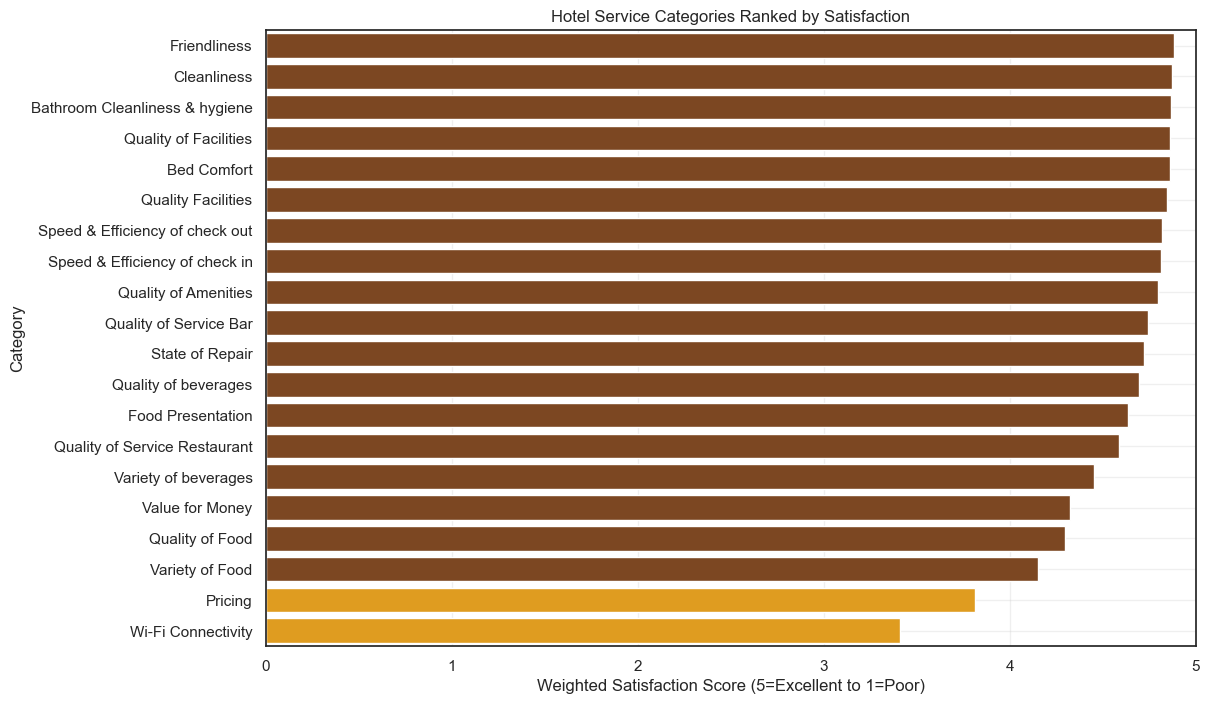

In [25]:
# Cell 8: Visualization 4 - Category Rankings
plt.figure(figsize=(12, 8))
sns.barplot(y=avg_scores.index, 
            x=avg_scores['Weighted Score'], 
            palette=['#8B4513' if x > 4 else '#FFA500' if x > 3 else '#D2B48C' for x in avg_scores['Weighted Score']])
plt.title('Hotel Service Categories Ranked by Satisfaction')
plt.xlabel('Weighted Satisfaction Score (5=Excellent to 1=Poor)')
plt.xlim(0, 5)
plt.grid(True, alpha=0.3)
plt.show()

## Excellent to Poor ratings
Calculate Jan-Apr changes in Excellent/Poor ratings to identify which aspects are improving or declining, regardless of their absolute scores.

In [28]:
# Cell 9: Trend Analysis
def analyze_trends(df):
    trends = []
    for category in df['Category'].unique():
        cat_data = df[df['Category'] == category]
        if len(cat_data) == 4:  # Only complete monthly data
            jan = cat_data[cat_data['Month'] == 'January']
            apr = cat_data[cat_data['Month'] == 'April']
            trends.append({
                'Category': category,
                'Excellent Change': apr['Excellent %'].values[0] - jan['Excellent %'].values[0],
                'Poor Change': apr['Poor %'].values[0] - jan['Poor %'].values[0]
            })
    return pd.DataFrame(trends)

trend_df = analyze_trends(percentages)

print("Most Improved Categories:")
trend_df.sort_values('Excellent Change', ascending=False).head(10)

Most Improved Categories:


,Category,Excellent Change,Poor Change
11,Quality of Food,62.083333,0.000000
15,Variety of beverages,60.714286,0.000000
12,Variety of Food,54.807692,0.000000
16,Pricing,50.000000,-12.500000
17,Quality of Service Bar,42.857143,0.000000
1,State of Repair,36.190476,0.000000
13,Quality of Service Restaurant,35.000000,-6.666667
18,Value for Money,33.333333,0.000000
10,Wi-Fi Connectivity,26.666667,26.666667
2,Cleanliness,23.015873,0.000000


# Forecast using Prophet
Use time series forecasting to predict future satisfaction trends for Wi-Fi (typically the most problematic area) to inform resource allocation decisions.

C:\Users\jack\AppData\Local\Temp\ipykernel_21940\3866557378.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wifi_ts['Month'] = pd.to_datetime(wifi_ts['Month'] + ' 2025')
08:25:51 - cmdstanpy - INFO - Chain [1] start processing
08:25:51 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\jack\Documents\Flatiron\envs\hunterz\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


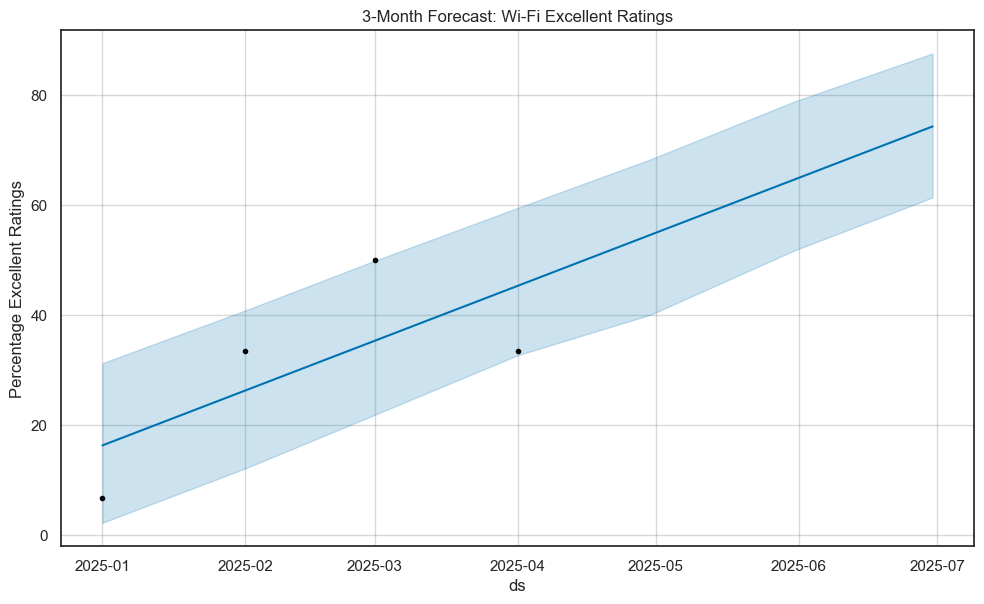

In [29]:
# Cell 10: Forecasting with Prophet
wifi_ts = percentages[percentages['Category'] == 'Wi-Fi Connectivity'][['Month', 'Excellent %']]
wifi_ts['Month'] = pd.to_datetime(wifi_ts['Month'] + ' 2025')
wifi_ts = wifi_ts.rename(columns={'Month': 'ds', 'Excellent %': 'y'})

model = Prophet(seasonality_mode='multiplicative')
model.fit(wifi_ts)
future = model.make_future_dataframe(periods=3, freq='M')
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('3-Month Forecast: Wi-Fi Excellent Ratings')
plt.ylabel('Percentage Excellent Ratings')
plt.grid(True, alpha=0.3)
plt.show()

# Correlation
Identify relationships between different service aspects - for example, whether improvements in one area (like cleanliness) correlate with improvements in others (like overall satisfaction).